In [1]:
!pip install bertopic

     |████████████████████████████████| 143 kB 167 kB/s eta 0:00:01
     |████████████████████████████████| 14.8 MB 195 kB/s eta 0:00:01
     |████████████████████████████████| 255 kB 148 kB/s eta 0:00:01
     |████████████████████████████████| 88 kB 174 kB/s eta 0:00:01
     |████████████████████████████████| 4.3 MB 255 kB/s eta 0:00:01
     |████████████████████████████████| 339 kB 243 kB/s eta 0:00:01
     |████████████████████████████████| 3.7 MB 144 kB/s eta 0:00:01
     |████████████████████████████████| 56 kB 188 kB/s eta 0:00:01
     |████████████████████████████████| 43.6 MB 74 kB/s eta 0:00:017


In [4]:
!pip install -U sentence-transformers


Requirement already up-to-date: sentence-transformers in /sdb/bert/.venv/lib/python3.8/site-packages (3.2.1)


In [1]:
import os
import pandas as pd
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer, models
from transformers import AutoModel, AutoTokenizer
import torch


BERTopic training

In [ ]:
import pandas as pd
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
import plotly.express as px

# Load Data
df = pd.read_csv("D:/Resilience/output_all.csv")
docs = df["Abstract"].dropna().astype(str).tolist()

# Initialize Embedding Model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Define BERTopic Model
# Configure UMAP for dimensionality reduction
umap_model = UMAP(
    n_neighbors=5,
    n_components=2,
    min_dist=0.0,
    metric='cosine',
    random_state=42
)
# Configure HDBSCAN clustering model
hdbscan_model = HDBSCAN(
    min_cluster_size=39,
    min_samples=27,
    metric='euclidean',
    prediction_data=True
)

#Configure text vectorizer
vectorizer_model = CountVectorizer(stop_words="english")  

# Initialize BERTopic model
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    language="english",  
    calculate_probabilities=True,
    verbose=True
)

#Fit Model and Extract Topics
topics, probs = topic_model.fit_transform(docs)


topic_freq = topic_model.get_topic_info()
print(topic_freq)

2025-06-18 19:04:34,640 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/389 [00:00<?, ?it/s]

2025-06-18 19:18:58,764 - BERTopic - Embedding - Completed ✓
2025-06-18 19:18:58,771 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-18 19:19:49,243 - BERTopic - Dimensionality - Completed ✓
2025-06-18 19:19:49,255 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-18 19:19:53,800 - BERTopic - Cluster - Completed ✓
2025-06-18 19:19:53,822 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-06-18 19:19:57,868 - BERTopic - Representation - Completed ✓


    Topic  Count                                               Name  \
0      -1   3571                  -1_flood_urban_resilience_climate   
1       0   1265                   0_heat_thermal_urban_temperature   
2       1    934             1_climate_adaptation_change_resilience   
3       2    544                           2_green_nature_urban_nbs   
4       3    350                  3_water_supply_systems_management   
5       4    289                         4_drought_sic_species_tree   
6       5    258                           5_coastal_wave_sea_beach   
7       6    221               6_ecological_resilience_china_carbon   
8       7    219              7_network_road_transportation_traffic   
9       8    200                8_climate_migration_change_informal   
10      9    182                  9_wildfire_wildfires_wui_wildland   
11     10    180            10_coastal_vulnerability_sea_adaptation   
12     11    178                11_air_pollution_pm2_concentrations   
13    

In [ ]:
df = df.loc[df["Abstract"].notna()].copy()

df["Topic"] = topics

main_topic_probs = [prob[t] if t != -1 else None for t, prob in zip(topics, probs)]
df["Topic_Probability"] = main_topic_probs

topic_representations = topic_model.get_topics()
df["Topic_Keywords"] = df["Topic"].apply(
    lambda t: ", ".join([word for word, _ in topic_representations[t]]) if t in topic_representations else "None"
)

df.to_csv("output_with_topics.csv", index=False)

保存成功：output_with_topics.csv


Re-visualize using UMAP (2D) dimensionality reduction

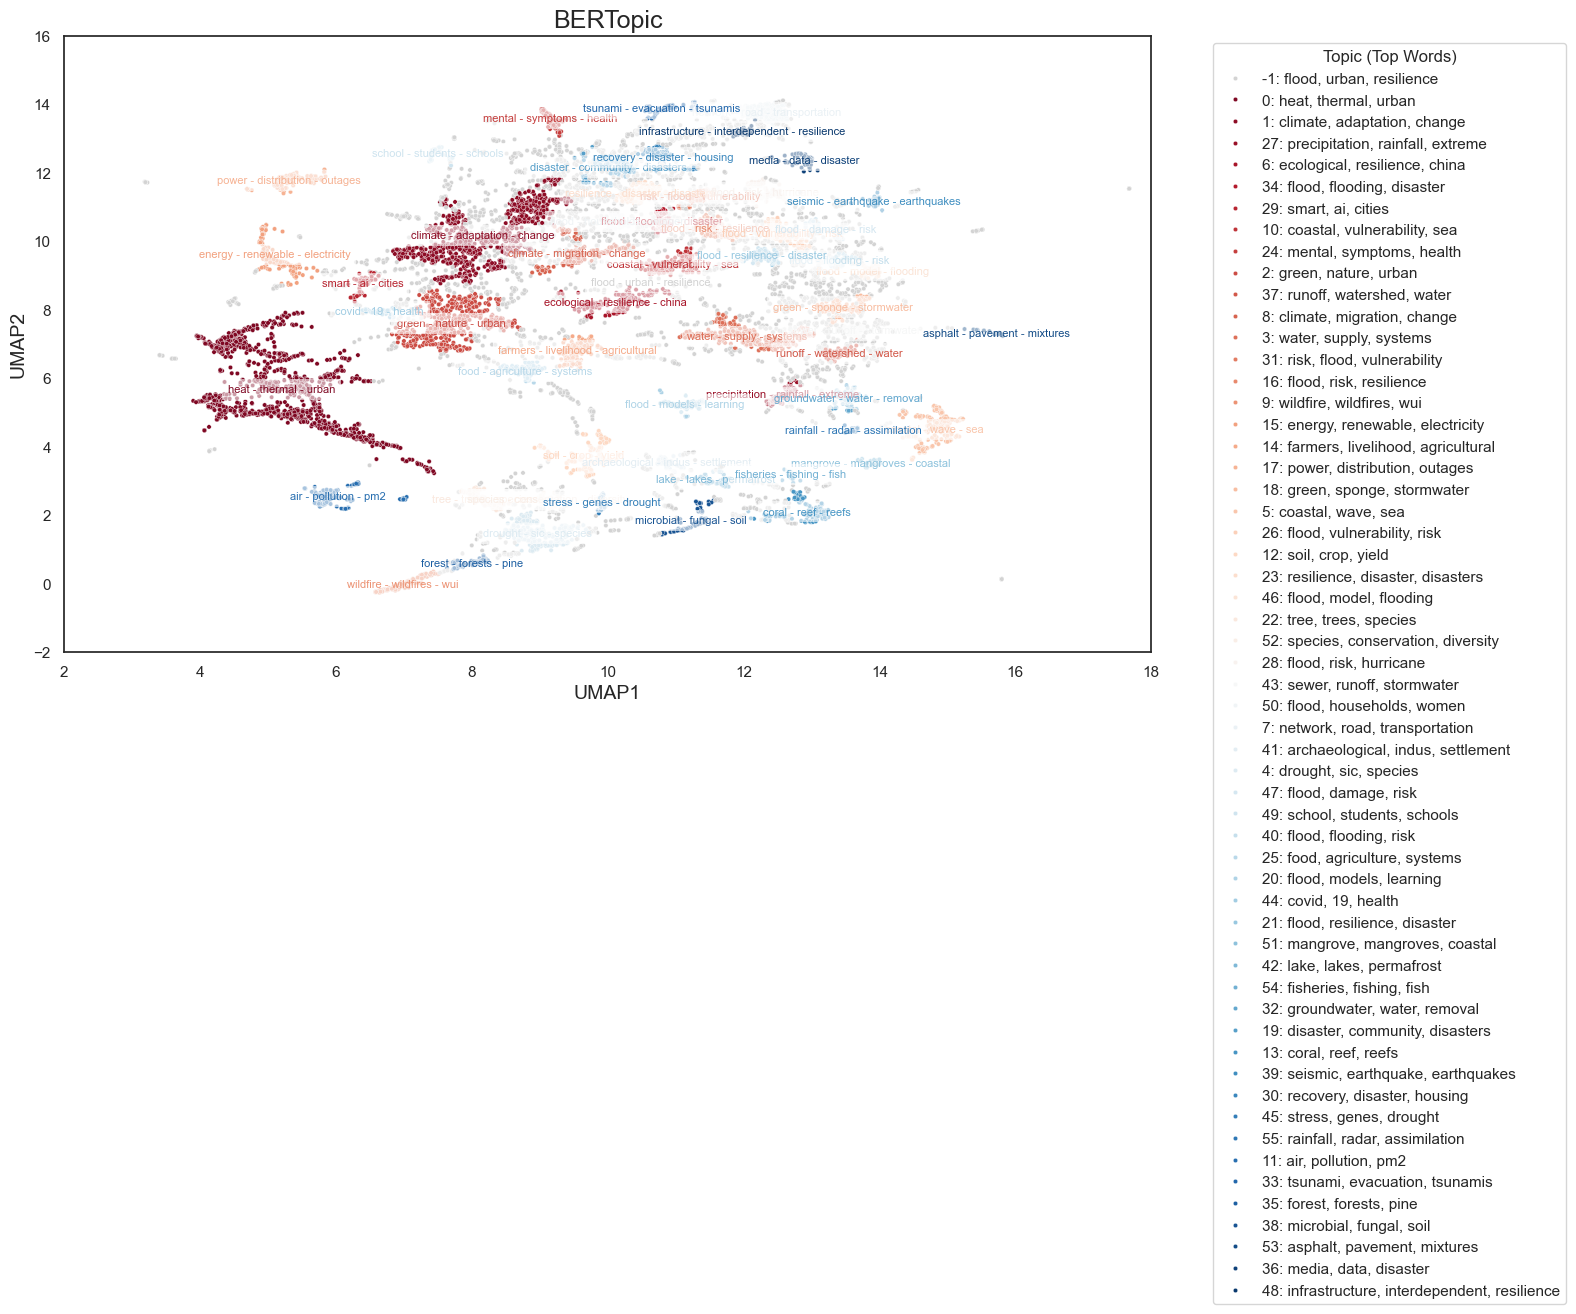

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import cm

sns.set(style="white")
plt.figure(figsize=(16, 11))


topic_labels_unique = viz_df["Topic_str"].unique()

def get_topic_num(label):
    return int(label.split(":")[0])

topic_nums = [get_topic_num(lbl) for lbl in topic_labels_unique]

non_minus1_idx = [i for i, num in enumerate(topic_nums) if num != -1]
non_minus1_labels = [topic_labels_unique[i] for i in non_minus1_idx]

minus1_labels = [topic_labels_unique[i] for i, num in enumerate(topic_nums) if num == -1]

palette_hsv = sns.color_palette("RdBu", n_colors=len(non_minus1_labels) + 1)
non_minus1_colors = palette_hsv[1:]

topic_color_map = {}

for lbl, color in zip(non_minus1_labels, non_minus1_colors):
    topic_color_map[lbl] = color

for lbl in minus1_labels:
    topic_color_map[lbl] = "#d3d3d3"  # lightgray

sns.scatterplot(
    data=viz_df,
    x="UMAP1",
    y="UMAP2",
    hue="Topic_str",
    palette=topic_color_map,
    s=10,
    legend='full'
)

# Add labels
for lbl in topic_labels_unique:
    keywords = lbl.split(":")[1].strip().split(", ")[:3] 
    keywords_text = " - ".join(keywords)  
    
    topic_points = viz_df[viz_df["Topic_str"] == lbl][["UMAP1", "UMAP2"]]
    
    if not topic_points.empty:
        centroid = topic_points.mean()
        x, y = centroid["UMAP1"], centroid["UMAP2"]
        
        plt.text(
            x, y,
            keywords_text,
            color=topic_color_map[lbl],
            fontsize=8,
            weight='regular',
            ha='center',
            va='center',
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='none') 
        )
            

plt.title("BERTopic", fontsize=18)
plt.xlabel("UMAP1", fontsize=14)
plt.ylabel("UMAP2", fontsize=14)
plt.xlim(2, 18)
plt.ylim(-2, 16)

plt.legend(title="Topic (Top Words)", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("D:/PHD/bertopic_keywords_2.svg", format="svg", bbox_inches="tight")
plt.show()

Exporting clustering results

In [ ]:
import pandas as pd
import numpy as np

embeddings = embedding_model.encode(docs, show_progress_bar=True)


umap_vis = UMAP(n_components=2, random_state=42, metric="cosine")
reduced_embeddings = umap_vis.fit_transform(embeddings)


topic_keywords = {}
for topic_num in set(topics):
    words = topic_model.get_topic(topic_num)
    if words:
        top_words = ", ".join([word for word, _ in words[:10]])  # 前10关键词
        topic_keywords[topic_num] = top_words
    else:
        topic_keywords[topic_num] = "N/A"


results_df = pd.DataFrame({
    "Abstract": docs,
    "Topic": topics,
    "Probability": [max(p) if p is not None else None for p in probs],
    "Top_Words": [topic_keywords.get(t, "N/A") for t in topics],
    "UMAP1": reduced_embeddings[:, 0],
    "UMAP2": reduced_embeddings[:, 1]
})


results_df.to_csv("D:/Resilience/BERTopic_Results_Complete.csv", index=False)


In [ ]:
hierarchical_topics = topic_model.hierarchical_topics(docs)

topic_model.visualize_hierarchy()


100%|██████████| 55/55 [00:00<00:00, 84.12it/s] 


Create hierarchical_topics

In [ ]:
import pandas as pd
import numpy as np
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from scipy.cluster.hierarchy import linkage


hierarchical_topics = topic_model.hierarchical_topics(docs)


print("Type of hierarchical_topics:", type(hierarchical_topics))
print("hierarchical_topics:", hierarchical_topics)


try:
    linkage_matrix = topic_model.topic_hierarchy_
    print("Linkage Matrix obtained successfully")
except AttributeError:
    try:
        topic_embeddings = topic_model.get_topic_info()['Representation'].values
        linkage_matrix = linkage(topic_embeddings, method='ward')
        print("Linkage Matrix created manually")
    except Exception as e:
        print(f"Could not create linkage matrix: {e}")
        linkage_matrix = None


if linkage_matrix is not None:
    def get_topic_keywords(topic_model, index):
        try:
            return ", ".join([word for word, _ in topic_model.get_topic(index)])
        except:
            return "N/A"

    
    linkage_df = pd.DataFrame(linkage_matrix, columns=["Topic 1", "Topic 2", "Distance", "Sample Count"])
    
   
    linkage_df["Topic 1 Keywords"] = linkage_df["Topic 1"].apply(lambda x: get_topic_keywords(topic_model, int(x)))
    linkage_df["Topic 2 Keywords"] = linkage_df["Topic 2"].apply(lambda x: get_topic_keywords(topic_model, int(x)))
    
    
    linkage_df.to_csv("topic_hierarchy.csv", index=False)
    print("Linkage DataFrame saved to topic_hierarchy.csv")


try:
    fig = topic_model.visualize_hierarchy()
    fig.write_html("hierarchical_topics.html")
    print("Hierarchy visualization saved to hierarchical_topics.html")
except Exception as e:
    print(f"Could not create hierarchy visualization: {e}")




100%|██████████| 55/55 [00:00<00:00, 100.33it/s]


Type of hierarchical_topics: <class 'pandas.core.frame.DataFrame'>
hierarchical_topics:    Parent_ID                                        Parent_Name  \
54       110              urban_climate_resilience_study_change   
53       109              climate_urban_change_resilience_study   
52       108               urban_climate_resilience_change_heat   
51       107                   urban_climate_heat_change_cities   
50       106                species_coastal_tree_forest_drought   
49       105              energy_network_power_resilience_model   
48       104                   urban_climate_heat_change_cities   
47       103     energy_network_power_transportation_resilience   
46       102                  species_tree_drought_forest_trees   
45       101     tsunami_evacuation_seismic_earthquake_concrete   
44       100       flood_risk_disaster_resilience_vulnerability   
43        99                food_farmers_crop_agricultural_soil   
42        98                        coast

Bayesian hyperparameter optimization-ALL

In [ ]:
import numpy as np
import pandas as pd
from hyperopt import fmin, tpe, hp, STATUS_OK, space_eval, Trials
from functools import partial
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.metrics import silhouette_score
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer


df = pd.read_csv("D:/Resilience/output_ai_use_1.csv.csv")
#docs = df["Abstract"].dropna().astype(str).tolist()
docs = df["Abstract"].dropna().astype(str).tolist()

embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(docs, show_progress_bar=True)


space = {
    "n_neighbors": hp.quniform("n_neighbors", 5, 50, 1),
    "n_components": hp.quniform("n_components", 2, 10, 1),
    "min_cluster_size": hp.quniform("min_cluster_size", 10, 100, 1),
    "min_samples": hp.quniform("min_samples", 1, 50, 1),
    "random_state": hp.choice("random_state", [42])
}


def objective_function(params, embeddings):
    try:
        umap_model = UMAP(
            n_neighbors=int(params["n_neighbors"]),
            n_components=int(params["n_components"]),
            min_dist=0.0,
            metric="cosine",
            random_state=42
        )
        reduced_embeddings = umap_model.fit_transform(embeddings)

        hdbscan_model = HDBSCAN(
            min_cluster_size=int(params["min_cluster_size"]),
            min_samples=int(params["min_samples"]),
            metric="euclidean",
            prediction_data=True
        )
        cluster_labels = hdbscan_model.fit_predict(reduced_embeddings)

        n_noise = np.sum(cluster_labels == -1)
        n_total = len(cluster_labels)
        noise_ratio = n_noise / n_total

        valid_idx = cluster_labels != -1
        if np.sum(valid_idx) <= 2:
            return {'loss': 1.0, 'status': STATUS_OK}

        n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
        silhouette = silhouette_score(reduced_embeddings[valid_idx], cluster_labels[valid_idx])

        loss = noise_ratio + (1 - silhouette)

        return {'loss': loss, 'status': STATUS_OK}

    except Exception as e:
        print("Error:", e)
        return {'loss': 1.0, 'status': STATUS_OK}


def bayesian_search(embeddings, space, max_evals=30):
    trials = Trials()
    fmin_obj = partial(objective_function, embeddings=embeddings)

    best = fmin(
        fn=fmin_obj,
        space=space,
        algo=tpe.suggest,
        max_evals=max_evals,
        trials=trials
    )

    best_params = space_eval(space, best)
    print("Best parameters:", best_params)
    return best_params


best_params = bayesian_search(embeddings, space, max_evals=30)


best_umap = UMAP(
    n_neighbors=int(best_params["n_neighbors"]),
    n_components=int(best_params["n_components"]),
    min_dist=0.0,
    metric="cosine",
    random_state=42
)

best_hdbscan = HDBSCAN(
    min_cluster_size=int(best_params["min_cluster_size"]),
    min_samples=int(best_params["min_samples"]),
    metric="euclidean",
    prediction_data=True
)

topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=best_umap,
    hdbscan_model=best_hdbscan,
    vectorizer_model=CountVectorizer(stop_words="english"),
    language="english",
    calculate_probabilities=True,
    verbose=True
)

topics, probs = topic_model.fit_transform(docs, embeddings)

topic_model.save("bertopic_best_model")


Batches:   0%|          | 0/389 [00:00<?, ?it/s]

100%|██████████| 30/30 [13:00<00:00, 26.03s/trial, best loss: 0.7786031698446978]
Best parameters: {'min_cluster_size': 39.0, 'min_samples': 27.0, 'n_components': 2.0, 'n_neighbors': 5.0, 'random_state': 42}


2025-05-30 17:21:00,850 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-30 17:21:10,766 - BERTopic - Dimensionality - Completed ✓
2025-05-30 17:21:10,769 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-30 17:21:15,080 - BERTopic - Cluster - Completed ✓
2025-05-30 17:21:15,132 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-30 17:21:18,545 - BERTopic - Representation - Completed ✓
2025-05-30 17:21:20,859 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.
